# Train an anti-aliased U-net based GAN

## Imports and GPU identification

In [1]:
import tensorflow as tf
import os
from PIL import Image
from scipy import special
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib
from datetime import datetime

print(device_lib.list_local_devices())
print(tf.config.experimental.get_memory_info("/device:GPU:0")['current'])

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7125220939496434110
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4986830848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1456492307746291894
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


AttributeError: module 'tensorflow_core._api.v2.config.experimental' has no attribute 'get_memory_info'

## Circularly symmetric low-pass or anti-aliasing filter

Kernel:


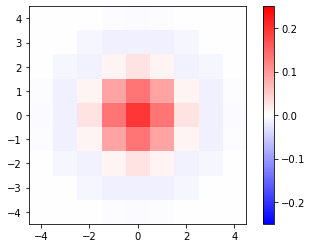

Frequency response:


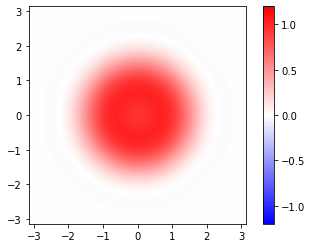

In [2]:
oversampling = 2  # Oversampling factor, 2 is a good choice
aa_kernel_w = 9  # Horizontal size of the kernel, also its vertical size. Must be odd. 9 is a good choice when oversampling == 2.

def circularLowpassKernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size, must be odd.
  with np.errstate(divide='ignore',invalid='ignore'):    
      kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N])
  kernel[(N - 1)//2, (N - 1)//2] = omega_c**2/(4*np.pi)
  return kernel 

def rotatedCosineWindow(N):  # N = horizontal size of the targeted kernel, also its vertical size, must be odd.
  return np.fromfunction(lambda y, x: np.maximum(np.cos(np.pi/2*np.sqrt(((x - (N - 1)/2)/((N - 1)/2 + 1))**2 + ((y - (N - 1)/2)/((N - 1)/2 + 1))**2)), 0), [N, N])

aa_kernel_cutoff_pi = circularLowpassKernel(np.pi/oversampling, aa_kernel_w)*rotatedCosineWindow(aa_kernel_w)

print("Kernel:")
plt.imshow(aa_kernel_cutoff_pi, vmin=-0.25, vmax=0.25, cmap='bwr', extent=[-aa_kernel_w/2, aa_kernel_w/2, -aa_kernel_w/2, aa_kernel_w/2])
plt.colorbar()
plt.show()

print("Frequency response:")
freq_resp = np.real(np.fft.fftshift(np.fft.fft2(np.roll(np.pad(aa_kernel_cutoff_pi, 100, mode = 'constant', constant_values = 0), shift = (-aa_kernel_w//2-99, -aa_kernel_w//2-99), axis = (0, 1)))))
plt.imshow(freq_resp, vmin=-1.2, vmax=1.2, cmap='bwr', extent=[-np.pi, np.pi, -np.pi, np.pi])
plt.colorbar()
plt.show()

aa_kernel_cutoff_pi = tf.repeat(tf.expand_dims(tf.constant(aa_kernel_cutoff_pi, dtype=tf.float32), 2), 3, axis=2)
aa_kernel_cutoff_pi = tf.expand_dims(aa_kernel_cutoff_pi, -1) # (height, width, output channels, input channels)

## Load training target images and low-pass filter them

Note: Do NOT use the filtered PNG images as network input, because they have been quantized. They are saved for visual inspection.

In [3]:
approx_batch_size = 100
target_w_and_h = 128

photos_dir = "C:/Users/romat/Desktop/somefolder"
#save_filtered_photos_dir = "C:/Users/romat/Desktop/somefolder" # save folder, or None to disable saving

def load_and_filter_image(filepath):
    image = tf.io.decode_png(tf.io.read_file(filepath), channels=3, dtype=tf.dtypes.uint8)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) * 2 - 1
    image = tf.nn.depthwise_conv2d([image], aa_kernel_cutoff_pi, [1, 1, 1, 1], "VALID")[0]
    if save_filtered_photos_dir is not None:
        basename = tf.py_function(lambda string_tensor: os.path.basename(string_tensor.numpy()), [filepath], tf.string)
        tf.io.write_file(save_filtered_photos_dir + "/" + basename, tf.io.encode_png(tf.image.convert_image_dtype((image + 1)/2, dtype=tf.dtypes.uint8, saturate=True)))
    return image

train_dataset = tf.data.Dataset.list_files(photos_dir + "/*.png")
train_dataset = train_dataset.map(load_and_filter_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache() # Load photos now instead of doing it again for each copy made in the next line
train_dataset = train_dataset.repeat(tf.math.floordiv(approx_batch_size, train_dataset.cardinality()))
train_dataset = train_dataset.cache()

print(train_dataset.cardinality())

NameError: in converted code:

    <ipython-input-3-d81bb91d5bc1>:11 load_and_filter_image  *
        if save_filtered_photos_dir is not None:

    NameError: name 'save_filtered_photos_dir' is not defined


## Get a batch from the dataset
This should be done in the beginning of each epoch

In [38]:
train_batch = train_dataset.map(lambda image: tf.image.random_crop(image, [target_w, target_w, 3]), num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)

for image in train_batch:
    print(image)

tf.Tensor(
[[[-0.24939495 -0.17824368 -0.60039896]
  [-0.78599864 -0.7243659  -0.94729525]
  [-0.9799394  -0.9133609  -1.0755165 ]
  ...
  [-0.1450568  -0.07400327 -0.62310714]
  [ 0.2395788   0.31646484 -0.24916945]
  [ 0.519253    0.60063183  0.03130128]]

 [[-0.14227086 -0.06410981 -0.5353024 ]
  [-0.7235829  -0.65277225 -0.94100124]
  [-0.9122469  -0.83461803 -1.0876726 ]
  ...
  [-0.12406015 -0.04733903 -0.6057846 ]
  [ 0.2152728   0.2975127  -0.27098012]
  [ 0.50144845  0.5865453   0.01520367]]

 [[-0.02497243  0.06236549 -0.47305655]
  [-0.6317181  -0.54982936 -0.9326315 ]
  [-0.80196536 -0.71244264 -1.0834695 ]
  ...
  [-0.12700735 -0.04348104 -0.60843   ]
  [ 0.18092836  0.26853433 -0.30300894]
  [ 0.4787293   0.5666376  -0.0067934 ]]

 ...

 [[-0.52015924 -0.5522925  -0.8633072 ]
  [-0.38562322 -0.45792243 -0.81332314]
  [-0.05675627 -0.18590984 -0.6128625 ]
  ...
  [-0.62297773 -0.5961621  -0.9660171 ]
  [-0.66114867 -0.6404837  -1.0095997 ]
  [-0.6083478  -0.59942544 -0.971